<a href="https://colab.research.google.com/github/inseungkang/learningalgos/blob/main/readc3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Inseung_LearningAlgos/
!pip3 install c3d

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Inseung_LearningAlgos


In [21]:
import numpy as np
import pandas as pd
import os
import c3d
import matplotlib.pyplot as plt

file_name = os.listdir()

In [112]:
markerData = np.empty((36, 5, 1))
forceData = np.empty((18, 10, 1))

with open(file_name[0], 'rb') as handle:
  reader = c3d.Reader(handle)
  markerLabel = reader.point_labels
  forceLabel = reader.analog_labels
  
  markerName = ['RASI','LASI','RPSI','LPSI','RANL','LANL']
  forceName = ['RASI','LASI','RPSI','LPSI','RANL','LANL']

  idxList = []
  for _, name in enumerate(markerName):
    for idx, label in enumerate(markerLabel):
      if name == label.strip():
        idxList.append(idx)
      
  
  print(reader.analog_labels)
  
  # for _, (idx, marker, force) in enumerate(reader.read_frames()):
  #   print(reader)
  #   markerData = np.concatenate((markerData, np.expand_dims(marker, axis=2)), axis=2)
  #   forceData = np.concatenate((forceData, np.expand_dims(force, axis=2)), axis=2)
  #   if idx == 200:
  #     break

[34, 2, 0, 1, 20, 26]
['Force.Fx1       ' 'Force.Fy1       ' 'Force.Fz1       '
 'Moment.Mx1      ' 'Moment.My1      ' 'Moment.Mz1      '
 'Force.Fx2       ' 'Force.Fy2       ' 'Force.Fz2       '
 'Moment.Mx2      ' 'Moment.My2      ' 'Moment.Mz2      '
 'Force.Fx3       ' 'Force.Fy3       ' 'Force.Fz3       '
 'Moment.Mx3      ' 'Moment.My3      ' 'Moment.Mz3      ']


In [128]:
!c3d2npz AB1_Session1_Right14_Left14.c3d
# !c3d-metadata AB1_Session1_Right10_Left10.c3d

AB1_Session1_Right14_Left14.npz: saved 38148 x (36, 5) points, 38148 (18, 10) analog


In [149]:
indexList = [34, 2, 0, 1, 20, 26]
b = np.load('AB1_Session1_Right14_Left14.npz')
markerData = b['points']
forceData = b['analog']

# Extract all raw data into relevant marker and force data
# Truncate data with a sync force plate (for session 1, extracting 6 min)
force_sync = np.mean(forceData[:,14,:], axis=1)

trial_time = 6
start_idx = np.argwhere(abs(force_sync) > np.max(abs(force_sync))/2)[0,0]
end_idx = start_idx + trial_time*6000

foot_r = markerData[start_idx:end_idx, indexList[4], 0:3]
foot_l = markerData[start_idx:end_idx, indexList[5], 0:3]
com = np.mean(markerData[start_idx:end_idx, indexList[0:4], 0:3], axis=1)
force_r = np.mean(forceData[start_idx:end_idx, 0:3, :], axis=2)
force_l = np.mean(forceData[start_idx:end_idx, 6:9, :], axis=2)

(36000, 3)


(5000.0, 5500.0)

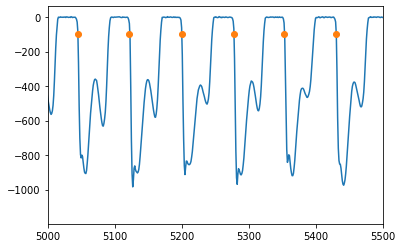

In [213]:
# Compute heel contact index for left and right leg
# r_idx = np.argwhere(force_r[:,2] < -100)[:,0]

# Obtain stance phase using force vector and compute heel contact index
stance_r = np.where(force_r[:,2] < -100, 1, np.zeros(len(force_r[:,2])))
stance_l = np.where(force_l[:,2] < -100, 1, np.zeros(len(force_l[:,2])))
idx_heel_r = np.where(np.diff(stance_r) == 1)[0]
idx_heel_l = np.where(np.diff(stance_l) == 1)[0]


x = np.arange(len(new_vec))
heel = np.ones(len(idx_heelcontact))*-100
plt.plot(x, force_r[:,2])
plt.plot(idx_heelcontact, heel,'o')
plt.xlim(5000, 5500)
